# Case Study: Eniac's A/B test

On the Eniac website the white “SHOP NOW” button takes pride of place in the primary banner, but only attracts about 2% of users, as determined by click-through rate (CTR), a common term in Online Marketing which typically describes the number of clicks an ad receives divided by the number of times the ad is shown. Here, click-through rate is measured as the number of clicks a website element receives divided by the total number of visits on the website. The report from the team analysing the website shows the specific numbers and explains how they reacted to them:

> *During the sample period from October 13, 2021 – October 20, 2021, which included 50,061 visits to the homepage, just under 2% of users clicked “SHOP NOW”. This did attract about twice the number of users as the “iPhone” link in the left sidebar, but contrasts with the surrounding banner itself, which gathered a CTR of roughly 3.5%. We asked ourselves if it may be visual features of the “SHOP NOW” button or if the text may feel simply too immediate a commitment to buying for users.*

In an A/B Test, one of the tasks that usually belongs to the UX team is to perform user research and develop a new version of the website element that needs to be tested. The team conducted an anonymous user survey, showing a de-branded mock-up of the homepage and asking “What do you think and feel seeing this ‘SHOP NOW’ button on an online retailer’s website?” A few responses are recorded below:

Holly, 32:

- “I’m on a shopping site, so it seems pretty natural to me. I would probably click it if I knew which items it would take me to.”

Ed, 57:

- “I like to do my research before I put anything in a basket. I’d like to see some product specs before I’m ready to ‘shop’.”

V., 16

- “Seems a little unnecessary. I came here to shop, so why is the website telling me to shop?”

Based on the feedback and reviewing some successful colour choices from previous ad-campaigns, the UX team asked web-design for the three new variations:
- white button with text 'SHOP NOW' (original)
- red button with text 'SHOP NOW'
- white button with text 'SEE DEALS'
- red button with text 'SEE DEALS'

## Analysis

In this notebook, I analyse the data collected during the sample period to determine whether any of the variant buttons were associated with a better click through rate than the original, using a chi-square test and post-hoc pairwise comparisons.

#### Import packages and read in the data

In [138]:
# import sys

# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install scipy
# !{sys.executable} -m pip install seaborn

In [139]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency

In [140]:
eniac_a = pd.read_csv('../data/eniac_a.csv')
eniac_b = pd.read_csv('../data/eniac_b.csv')
eniac_c = pd.read_csv('../data/eniac_c.csv')
eniac_d = pd.read_csv('../data/eniac_d.csv')

Create a dataframe with the necessary data from each dataset (number of clicks on 'SHOP NOW'/'SEE DEALS' and number of other clicks)

In [143]:
eniac_a.loc[eniac_a['Name']=='mySidebar', 'Snapshot information'].iloc[0]

'created 2021-09-14   •   14 days 0 hours 34 mins   •   25326 visits, 23174 clicks'

In [113]:
dfs = [eniac_a, eniac_b, eniac_c, eniac_d]
names = ['SHOP NOW','SHOP NOW','SEE DEALS','SEE DEALS']
clicks = pd.Series([df.loc[df['Name']==name, 'No. clicks'].squeeze() for df, name in zip(dfs, names)])
visits = pd.Series([df.loc[df['Name']=='mySidebar', 'Snapshot information'].str.extract(r'(\d+) visits').astype(int).squeeze() for df in dfs])
no_clicks = visits-clicks

eniac = pd.DataFrame([clicks.tolist(), no_clicks.tolist()], columns=["A", "B", "C", "D"], index=["Click", "No-click"])
eniac




,A,B,C,D
Click,512,281,527,193
No-click,24814,24466,24349,25040


Set alpha

In [114]:
alpha = 0.05

Run the chi-square test

In [115]:
chisq, p, df, expected = chi2_contingency(eniac)
print(f'chisq = {chisq}\np = {p}\ndf = {df}\nexpected = \n{expected}')

chisq = 224.01877488058412
p = 2.716121660786871e-48
df = 3
expected = 
[[  382.48625502   373.74189974   375.69012397   381.08172127]
 [24943.51374498 24373.25810026 24500.30987603 24851.91827873]]


Interpret the results

In [ ]:
if p < alpha:
    print('We can reject the null hypothesis - at least one variant differs from the others in its click-through-rate.')
else:
    print('We cannot reject the null hypothesis - there is no evidence that the variants differ in their click-through-rates.')

We can reject the null hypothesis - at least one variant differs from the others in its click-through-rate.


Perform post-hoc tests to determine if any of the variants perform better than the others

Adjust alpha to account for multiple testing

In [117]:
alpha_adj = 0.05/6

Run the post-hoc tests

In [118]:
eniac[['A','B']]

,A,B
Click,512,281
No-click,24814,24466


In [119]:
pairs = [[], [], [], [], [], []]
col_pairs = [['A','B'], ['A','C'], ['A','D'], ['B','C'], ['B','D'], ['C','D']]

for i in range(len(pairs)):
    chisq, p, df, expected = chi2_contingency(eniac[col_pairs[i]])
    pairs[i] = {'pair': col_pairs[i], 'chisq':chisq, 'p':p, 'df':df, 'expected':expected}

find pairs that differ significantly in their CTRs

In [130]:
click_rates = 100*eniac.loc['Click']/(eniac.loc['Click'] + eniac.loc['No-click'])
click_rates

A    2.021638
B    1.135491
C    2.118508
D    0.764871
dtype: float64

plot the CTRs

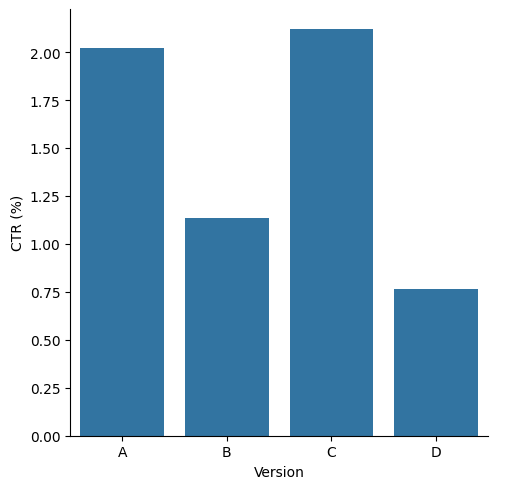

In [132]:
ctr = click_rates.reset_index()
ctr.columns = ['Version', 'CTR (%)']

sns.catplot(ctr,
            x = 'Version',
            y = 'CTR (%)',
            kind = 'bar');

Interpret the post-hoc results

In [133]:
for pair in pairs:
    if pair['p'] < alpha_adj:
        v1, v2 = pair['pair']
        winner = v1 if click_rates[v1] > click_rates[v2] else v2
        print(f'{winner} has a significantly higher CTR than {v2 if v1==winner else v1} (p = {pair['p']})')

A has a significantly higher CTR than B (p = 2.6730880539675666e-15)
A has a significantly higher CTR than D (p = 3.0808983951735623e-33)
C has a significantly higher CTR than B (p = 6.955480170773988e-18)
B has a significantly higher CTR than D (p = 2.3573374085176145e-05)
C has a significantly higher CTR than D (p = 6.450501398841207e-37)


Both A and C are significantly better than the others, but they do not differ from each other statistically.  
It seems like people click more on the white button regardless of whether it says 'SHOP NOW' or 'SEE DEALS'.

Recommendation:

As A is the original version, and it performs better than B and D, and no better than C, there is no reason to change the button to any of these variants.